In [8]:
import sys
sys.path.append('/content/drive/MyDrive/scripts')


 Using Device: cuda
------------------------------------------------------------

=== Evaluating Baseline Model ===
RMSE: 25.17 | MAE: 23.61 | Samples: 1679
------------------------------------------------------------


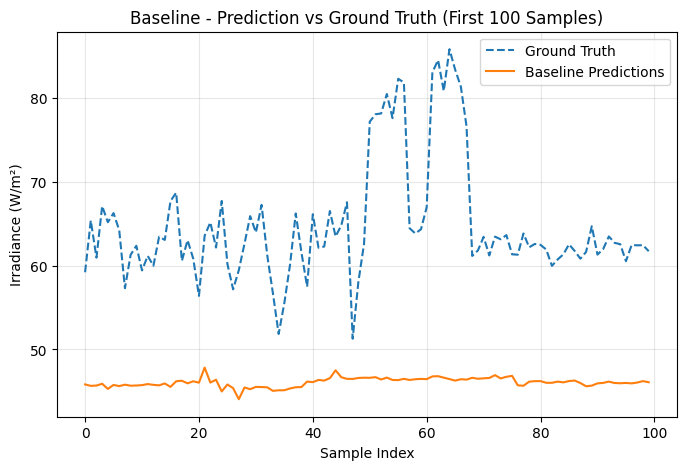


=== Evaluating Enhanced(Bicubic with colormap) Model ===
RMSE: 19.53 | MAE: 17.59 | Samples: 1679
------------------------------------------------------------


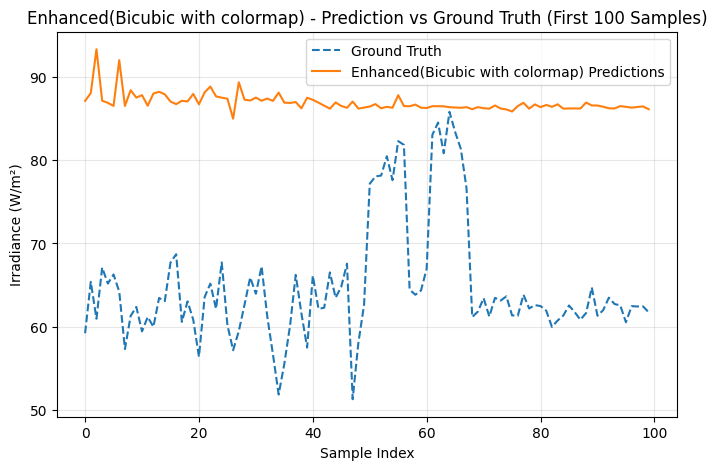


=== Model Comparison Summary ===
------------------------------------------------------------
Model           | RMSE (W/m²)  | MAE (W/m²)   | Samples 
------------------------------------------------------------
Baseline        | 25.17        | 23.61        | 1679    
Enhanced(Bicubic with colormap) | 19.53        | 17.59        | 1679    
------------------------------------------------------------
 Results saved to results/model_comparison.json


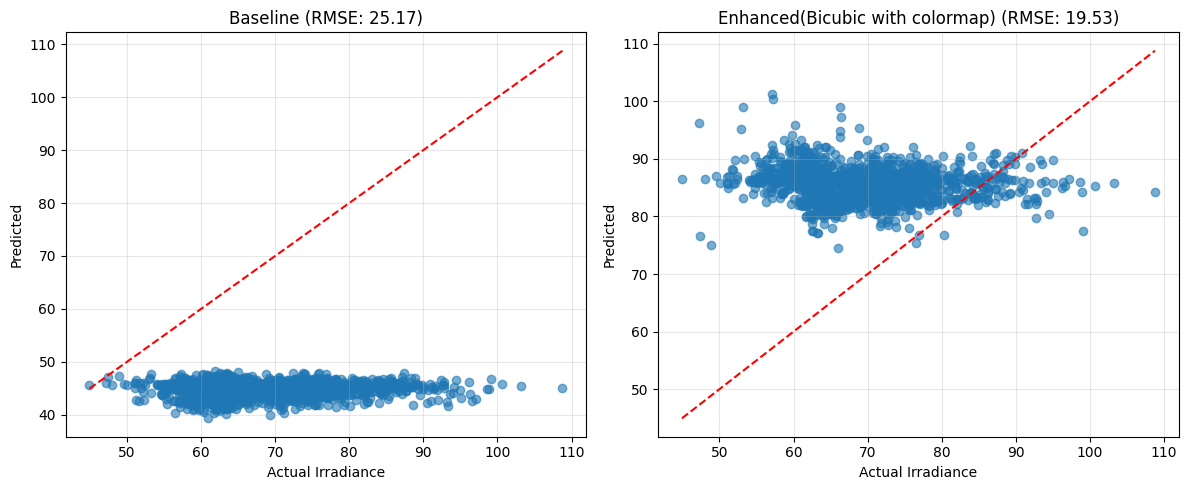

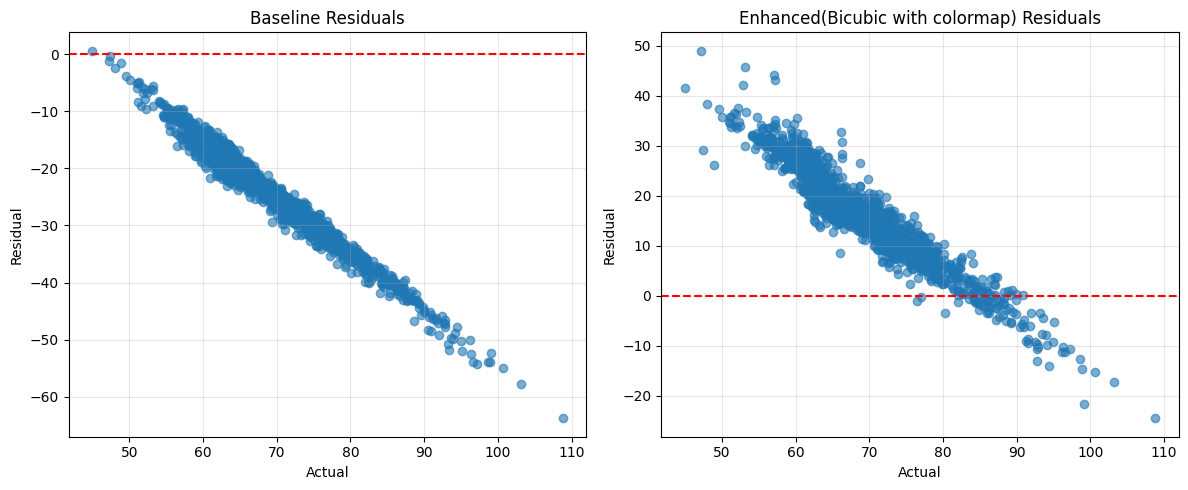

 Comparison plots saved in: results/plots


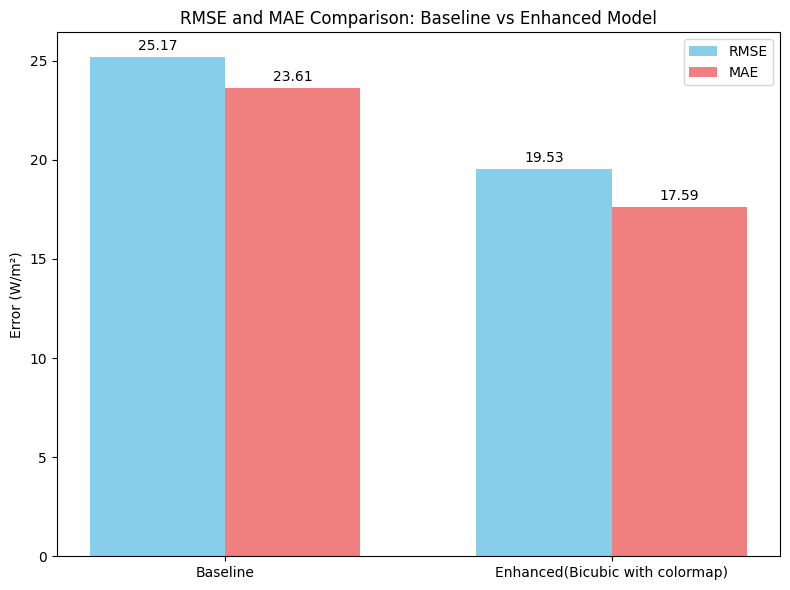

 Metrics bar chart saved in: results/plots

 Comparison completed successfully!
All outputs saved in 'results/' directory.
------------------------------------------------------------


In [ ]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from torch.utils.data import DataLoader
from datetime import datetime
import json

from solar_datasets import SolarIrradianceDataset
from efficientnet_model import EfficientNetRegression  # replace if needed


class CompareBaselineEnhanced:
    """Evaluate and Compare Baseline vs Enhanced Models (without R²)"""

    def __init__(self, device=None):
        self.device = device or torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f"\n Using Device: {self.device}")
        print("------------------------------------------------------------")
        self.results = {}

    def load_model(self, model_class, checkpoint_path, **kwargs):
        """Load model from checkpoint"""
        model = model_class(**kwargs).to(self.device)
        checkpoint = torch.load(checkpoint_path, map_location=self.device)
        model.load_state_dict(checkpoint["model_state_dict"])
        model.eval()
        return model

    def evaluate_model(self, model, model_name, test_dataset, batch_size=16):
        """Evaluate a single model on test data"""
        print(f"\n=== Evaluating {model_name} Model ===")
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
        preds, targets = [], []

        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(self.device), labels.to(self.device)
                outputs = model(images).squeeze()
                preds.extend(outputs.cpu().numpy())
                targets.extend(labels.cpu().numpy())

        preds, targets = np.array(preds), np.array(targets)
        mse = mean_squared_error(targets, preds)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(targets, preds)

        self.results[model_name] = {
            "RMSE": rmse,
            "MAE": mae,
            "Samples": len(preds),
            "Predictions": preds.tolist(),
            "Targets": targets.tolist(),
        }

        print(f"RMSE: {rmse:.2f} | MAE: {mae:.2f} | Samples: {len(preds)}")
        print("------------------------------------------------------------")
        return preds, targets

    def plot_predictions(self, preds, targets, model_name, save_dir="results/plots"):
        """Plot model predictions vs ground truth"""
        os.makedirs(save_dir, exist_ok=True)
        plt.figure(figsize=(8, 5))
        plt.plot(targets[:100], label="Ground Truth", linestyle="dashed")
        plt.plot(preds[:100], label=f"{model_name} Predictions")
        plt.title(f"{model_name} - Prediction vs Ground Truth (First 100 Samples)")
        plt.xlabel("Sample Index")
        plt.ylabel("Irradiance (W/m²)")
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.savefig(os.path.join(save_dir, f"{model_name}_predictions.png"), dpi=300, bbox_inches="tight")
        plt.show()
        plt.close()

    def plot_comparison(self, save_dir="results/plots"):
        """Plot scatter and residual comparison between baseline and enhanced"""
        os.makedirs(save_dir, exist_ok=True)
        if len(self.results) < 2:
            print("Need both models evaluated for comparison.")
            return

        m1, m2 = list(self.results.keys())
        t = np.array(self.results[m1]["Targets"])
        p1 = np.array(self.results[m1]["Predictions"])
        p2 = np.array(self.results[m2]["Predictions"])

        # Scatter Comparison
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.scatter(t, p1, alpha=0.6)
        plt.plot([t.min(), t.max()], [t.min(), t.max()], 'r--')
        plt.title(f"{m1} (RMSE: {self.results[m1]['RMSE']:.2f})")
        plt.xlabel("Actual Irradiance"); plt.ylabel("Predicted"); plt.grid(True, alpha=0.3)

        plt.subplot(1, 2, 2)
        plt.scatter(t, p2, alpha=0.6)
        plt.plot([t.min(), t.max()], [t.min(), t.max()], 'r--')
        plt.title(f"{m2} (RMSE: {self.results[m2]['RMSE']:.2f})")
        plt.xlabel("Actual Irradiance"); plt.ylabel("Predicted"); plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.savefig(os.path.join(save_dir, "scatter_comparison.png"), dpi=300, bbox_inches="tight")
        plt.show()
        plt.close()

        # Residuals
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.scatter(t, p1 - t, alpha=0.6)
        plt.axhline(0, color='r', linestyle='--')
        plt.title(f"{m1} Residuals"); plt.xlabel("Actual"); plt.ylabel("Residual"); plt.grid(True, alpha=0.3)

        plt.subplot(1, 2, 2)
        plt.scatter(t, p2 - t, alpha=0.6)
        plt.axhline(0, color='r', linestyle='--')
        plt.title(f"{m2} Residuals"); plt.xlabel("Actual"); plt.ylabel("Residual"); plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.savefig(os.path.join(save_dir, "residuals_comparison.png"), dpi=300, bbox_inches="tight")
        plt.show()

        plt.close()

        print(f" Comparison plots saved in: {save_dir}")

    def plot_metrics_bar_chart(self, save_dir="results/plots"):
        """Plot bar chart comparison of RMSE and MAE"""
        os.makedirs(save_dir, exist_ok=True)
        if len(self.results) < 2:
            print("❗Need both models evaluated for comparison.")
            return

        model_names = list(self.results.keys())
        model_1_name = model_names[0]
        model_2_name = model_names[1]

        rmse_values = [self.results[model_1_name]['RMSE'], self.results[model_2_name]['RMSE']]
        mae_values = [self.results[model_1_name]['MAE'], self.results[model_2_name]['MAE']]
        labels = [model_1_name, model_2_name]

        x = np.arange(len(labels))  # the label locations
        width = 0.35  # the width of the bars

        fig, ax = plt.subplots(figsize=(8, 6))
        rects1 = ax.bar(x - width/2, rmse_values, width, label='RMSE', color='skyblue')
        rects2 = ax.bar(x + width/2, mae_values, width, label='MAE', color='lightcoral')

        # Add some text for labels, title and custom x-axis tick labels, etc.
        ax.set_ylabel('Error (W/m²)')
        ax.set_title('RMSE and MAE Comparison: Baseline vs Enhanced Model')
        ax.set_xticks(x)
        ax.set_xticklabels(labels)
        ax.legend()


        def autolabel(rects):
            """Attach a text label above each bar in *rects*, displaying its height."""
            for rect in rects:
                height = rect.get_height()
                ax.annotate(f'{height:.2f}',
                            xy=(rect.get_x() + rect.get_width() / 2, height),
                            xytext=(0, 3),  # 3 points vertical offset
                            textcoords="offset points",
                            ha='center', va='bottom')

        autolabel(rects1)
        autolabel(rects2)

        fig.tight_layout()

        plot_path = os.path.join(save_dir, "metrics_bar_chart.png")
        plt.savefig(plot_path, dpi=300, bbox_inches="tight")
        plt.show()
        plt.close()
        print(f" Metrics bar chart saved in: {save_dir}")


    def display_results(self):
        """Print formatted results table"""
        print("\n=== Model Comparison Summary ===")
        print("------------------------------------------------------------")
        print(f"{'Model':<15} | {'RMSE (W/m²)':<12} | {'MAE (W/m²)':<12} | {'Samples':<8}")
        print("------------------------------------------------------------")
        for name, r in self.results.items():
            print(f"{name:<15} | {r['RMSE']:<12.2f} | {r['MAE']:<12.2f} | {r['Samples']:<8}")
        print("------------------------------------------------------------")

    def save_json(self, filename="results/model_comparison.json"):
        """Save results to JSON"""
        os.makedirs(os.path.dirname(filename), exist_ok=True)
        with open(filename, "w") as f:
            json.dump({
                "timestamp": datetime.now().isoformat(),
                "device": str(self.device),
                "results": self.results
            }, f, indent=2)
        print(f" Results saved to {filename}")


def run_baseline_vs_enhanced_evaluation():
    evaluator = CompareBaselineEnhanced()

    # Test data
    test_image_dir = "/content/drive/MyDrive/GIRASOL_DATASET/2019_01_15/infrared"
    test_label_file = "/content/drive/MyDrive/GIRASOL_DATASET/2019_01_15/pyranometer/2019_01_15.csv"
    test_dataset = SolarIrradianceDataset(image_dir=test_image_dir, irradiance_file=test_label_file)

    # Model paths
    baseline_path = "/content/drive/MyDrive/models(Baselien)/best_efficientnet_model (1).pth"
    enhanced_path = "/content/drive/MyDrive/models(CNN)/best_efficientnet_model.pth"

    # Evaluate Baseline
    if os.path.exists(baseline_path):
        baseline_model = evaluator.load_model(EfficientNetRegression, baseline_path)
        preds, targets = evaluator.evaluate_model(baseline_model, "Baseline", test_dataset)
        evaluator.plot_predictions(preds, targets, "Baseline")

    # Evaluate Enhanced
    if os.path.exists(enhanced_path):
        enhanced_model = evaluator.load_model(EfficientNetRegression, enhanced_path)
        preds, targets = evaluator.evaluate_model(enhanced_model, "Enhanced(Bicubic with colormap)", test_dataset)
        evaluator.plot_predictions(preds, targets, "Enhanced(Bicubic with colormap)")

    # Save + Compare
    evaluator.display_results()
    evaluator.save_json()
    evaluator.plot_comparison()
    evaluator.plot_metrics_bar_chart() # Add this line to generate the bar chart


    print("\n Comparison completed successfully!")
    print("All outputs saved in 'results/' directory.")
    print("------------------------------------------------------------")


if __name__ == "__main__":
    run_baseline_vs_enhanced_evaluation()